# Settings

In [1]:
DATA_CLEANED_PATH = "../data/cleaned_data.csv"

# Time series Analysis Preliminaries

In [2]:
import pandas as pd
data_tourism = pd.read_csv(DATA_CLEANED_PATH)

In [3]:
len(data_tourism)

4466

In [4]:
data_tourism["date"].describe(datetime_is_numeric=False), data_tourism["date"].max()

(count           4466
 unique            58
 top       2019-01-01
 freq              77
 Name: date, dtype: object,
 '2023-10-01')

In [5]:
data_tourism.dtypes

date                   object
province               object
region                 object
ratio_tourist_stay    float64
no_tourist_stay         int64
no_tourist_all          int64
no_tourist_thai         int64
no_tourist_foreign      int64
revenue_all             int64
revenue_thai            int64
revenue_foreign         int64
dtype: object

In [6]:
data_tourism["date"] = pd.to_datetime(data_tourism["date"])

## Matrix correlation
Between  revenue_all, revenue_thai, no_tourist_all, no_tourist_thai, ratio_tourist_stay, no_tourist_stay

province, region, all nation correlation

## "revenue_all" analysis

We focus on all nation

In [7]:
# Our problem is about sales, so in this notebook, we focus on revenue_all
data_tourism_revenue_all  = data_tourism[["date", "province", "region", "revenue_all"]]

## divide by 1e6 
import numpy as np
data_tourism_revenue_all["revenue_all"]  = data_tourism_revenue_all["revenue_all"].astype(np.float64) / 1e6

C:\Users\DUC\AppData\Local\Temp\ipykernel_17900\1076620876.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tourism_revenue_all["revenue_all"]  = data_tourism_revenue_all["revenue_all"].astype(np.float64) / 1e6


In [8]:
thai_revenue_all = data_tourism_revenue_all.groupby(["date"]).sum("revenue_all").reset_index()
thai_revenue_all.head()

,date,revenue_all
0,2019-01-01,257559.91
1,2019-02-01,231239.97
2,2019-03-01,233165.20
3,2019-04-01,227588.80
4,2019-05-01,206090.92


### Components of Time Series

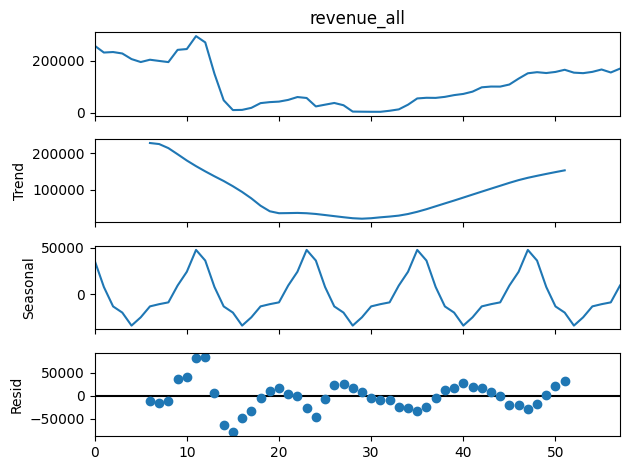

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomp = seasonal_decompose(thai_revenue_all["revenue_all"], model="add", period=12)
decomp.plot()
plt.show()

### Stationarity Testing
Dickey–Fuller test, ACF, PACF

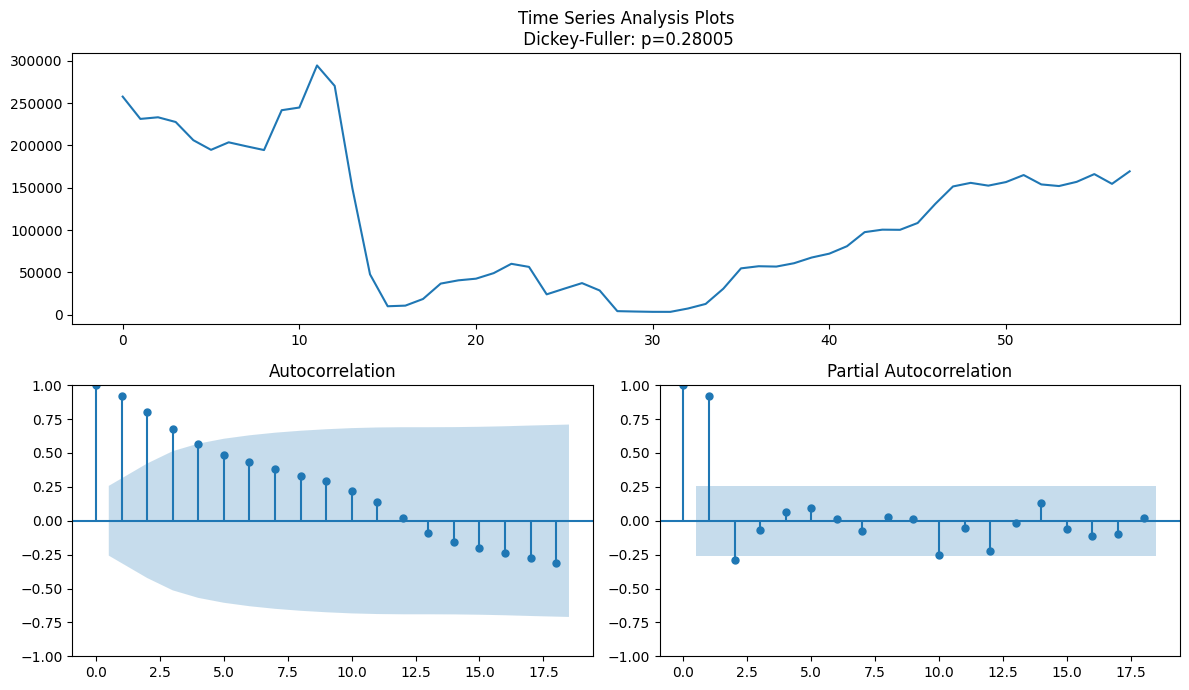

In [10]:
# Check if the revenue is stationary or not ?
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()


tsplot(thai_revenue_all["revenue_all"])

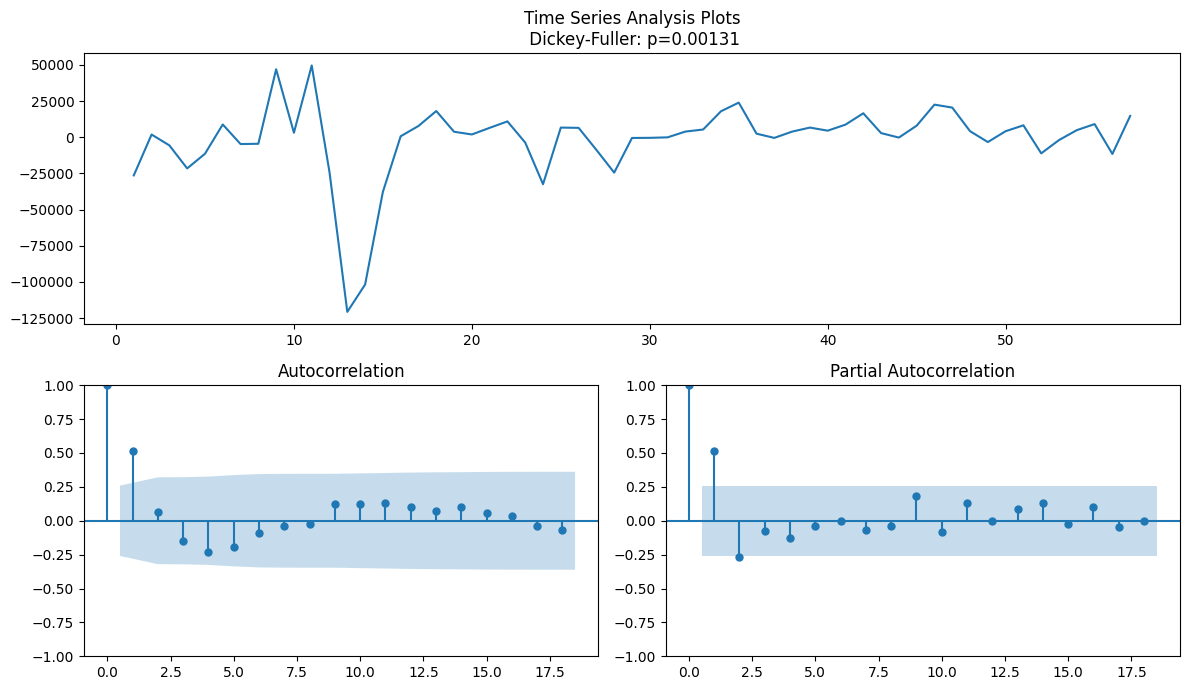

In [32]:
# We check for the difference ...
tsplot(thai_revenue_all["revenue_all"].diff().dropna())

# Modeling

## Forecast Metrics

MAPE, RMSEPE

In [11]:
import numpy as np

def forecast_metric(forecast, actual):
    forecast = np.array(forecast).flatten()
    actual = np.array(actual).flatten()

    mape_result = (np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100).round(2)
    rmspe_result = (
        (np.sqrt(np.mean(np.square((forecast - actual) / actual)))) * 100
    ).round(2)
    return {"MAPE": mape_result, "RMSPE": rmspe_result}

## Split training and test set

Hold out 12 months for evaluation

Forecasting 48 months 

In [319]:
HOLDOUT_MONTH = 12
FORECASTING_MONTH = 48
thai_revenue_all.shape

(58, 2)

In [320]:
thai_revenue_all.tail(5)

,date,revenue_all
53,2023-06-01,151966.899995
54,2023-07-01,156920.359995
55,2023-08-01,166056.739993
56,2023-09-01,154557.719994
57,2023-10-01,169347.069995


In [321]:
train_thai_revenue = thai_revenue_all[:-HOLDOUT_MONTH]
test_thai_revenue = thai_revenue_all[-HOLDOUT_MONTH:] 

## AR 

In [322]:
# Set index
train_data = train_thai_revenue.set_index("date")
test_data = test_thai_revenue.set_index("date")

In [323]:
import pmdarima as pm


ARIMAModel = pm.arima.ARIMA((1, 0, 0), suppress_warnings=True)
ARIMAModel.fit(train_data)
ARIMAModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -538.060
Date:                Thu, 21 Dec 2023   AIC                           1082.120
Time:                        16:59:11   BIC                           1087.606
Sample:                    01-01-2019   HQIC                          1084.175
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5083.4327   8197.592      0.620      0.535    -1.1e+04    2.12e+04
ar.L1          0.9619      0.046     20.818      0.000       0.871       1.052
sigma2      7.511e+08      0.247   3.04e+09      0.000    7.51e+08    7.51e+08
===================================================================================
Ljung-Box (L1) (Q):                  11.18   Jarque-Bera (JB):               112.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -1.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.68e+24. Standard errors may be unstable.
"""

In [324]:
forecast, forecast_int = ARIMAModel.predict(n_periods=HOLDOUT_MONTH, 
                                      return_conf_int=True,
                                      alpha=0.05)

In [325]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None, model_name=""):
    metrics = forecast_metric(forecast, series_test)
    plt.figure(figsize=(12, 6))
    plt.title(f"{model_name} Prediction with {metrics}", size=16)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int[:, 0],
            forecast_int[:, 1],
            alpha=0.05,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()
    return metrics


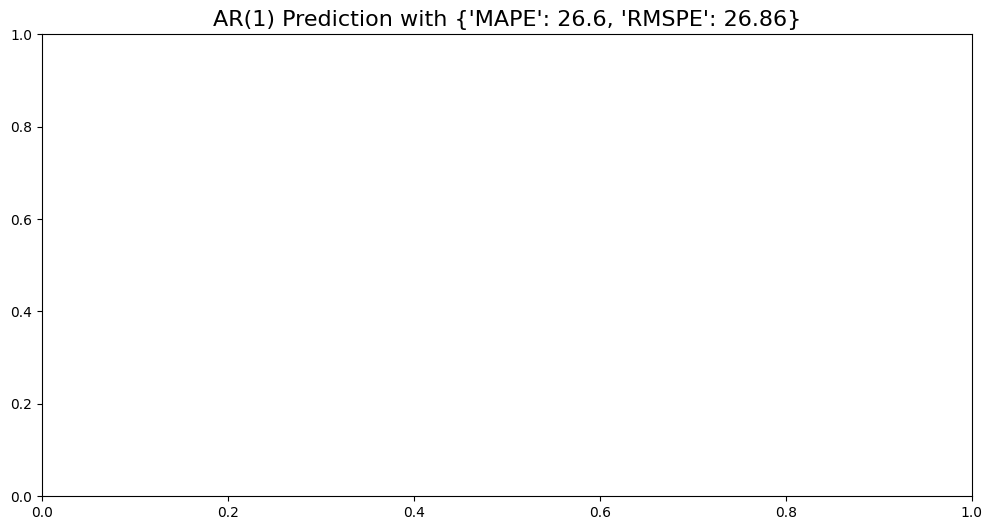

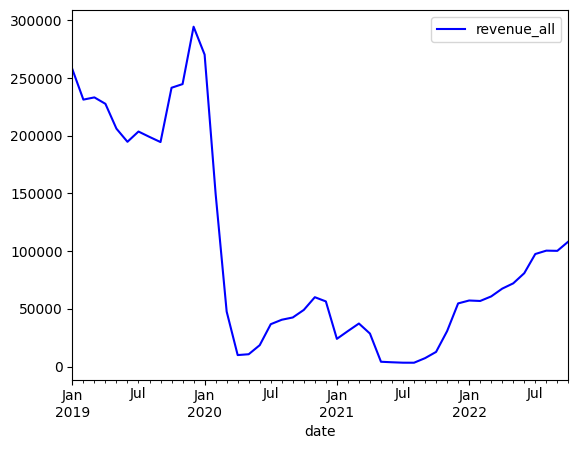

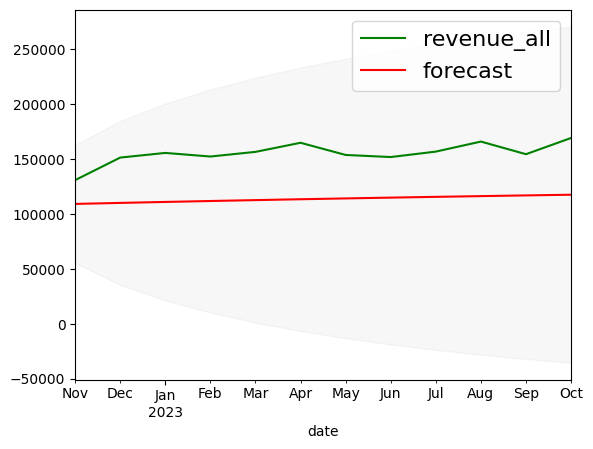

In [326]:
ar_metric = plot_forecast(train_data, 
              test_data,
              forecast,
              forecast_int,
              model_name="AR(1)")
plt.show()

## SARIMA

In [327]:
# Set index
# Set index
train_data = train_thai_revenue.set_index("date")
test_data = test_thai_revenue.set_index("date")

In [328]:
# test_thai_revenue.index[-1]
# Index
# index_months = pd.date_range(test_thai_revenue.index[-1] + pd.DateOffset(months=1), freq="MS", periods=FORECASTING_MONTH)
# index_months

In [329]:
import pmdarima as pm

SARIMAModel = pm.auto_arima(
                        train_data["revenue_all"],
                        start_p=1,
                        start_q=1, 
                        test= "adf",  # use adftest to find optimal 'd'
                        max_p=3,
                        max_q=3,
                        m=12,
                        start_P=0,
                        seasonal=True,
                        D=1,
                        alpha=0.05,
                        trace=False,
                        suppress_warnings=True,
                        stepwise=True)

SARIMAModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   46
Model:             SARIMAX(1, 2, 2)x(0, 1, 2, 12)   Log Likelihood                -375.003
Date:                            Thu, 21 Dec 2023   AIC                            762.006
Time:                                    16:59:30   BIC                            770.800
Sample:                                01-01-2019   HQIC                           764.921
                                     - 10-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4445      0.412      1.078      0.281      -0.364       1.253
ma.L1         -0.9167      0.692     -1.324      0.185      -2.273       0.440
ma.L2         -0.0463      0.369     -0.126      0.900      -0.769       0.676
ma.S.L12      -0.4052      0.607     -0.667      0.505      -1.595       0.785
ma.S.L24      -0.2463      0.131     -1.875      0.061      -0.504       0.011
sigma2      1.195e+09   6.14e-10   1.95e+18      0.000    1.19e+09    1.19e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                37.69
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             1.31
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+34. Standard errors may be unstable.
"""

In [330]:
forecast, forecast_int = SARIMAModel.predict(n_periods=HOLDOUT_MONTH, 
                                      return_conf_int=True,
                                      alpha=0.05)

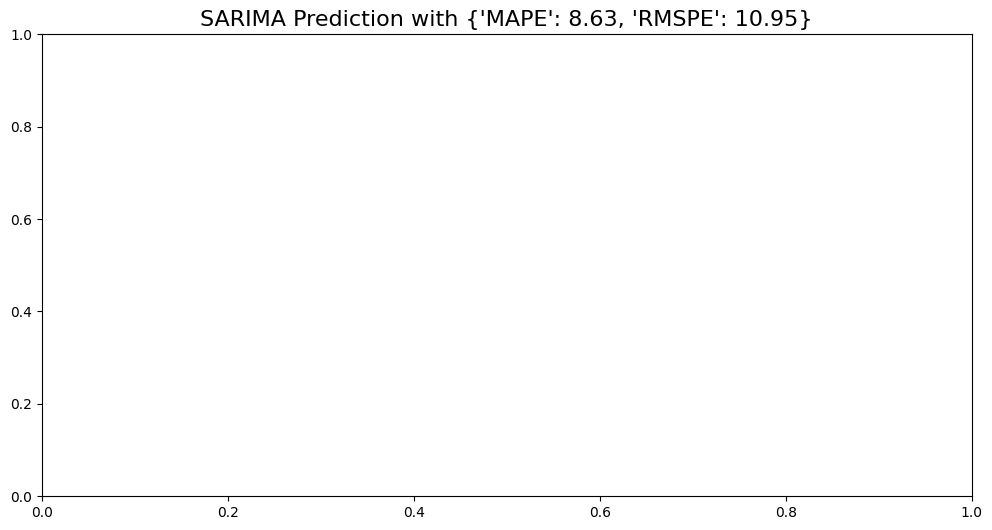

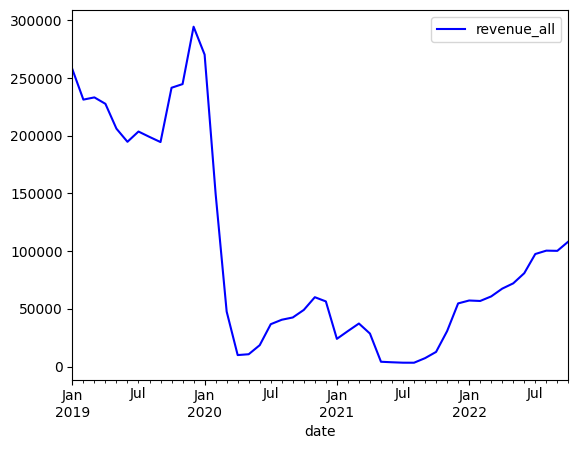

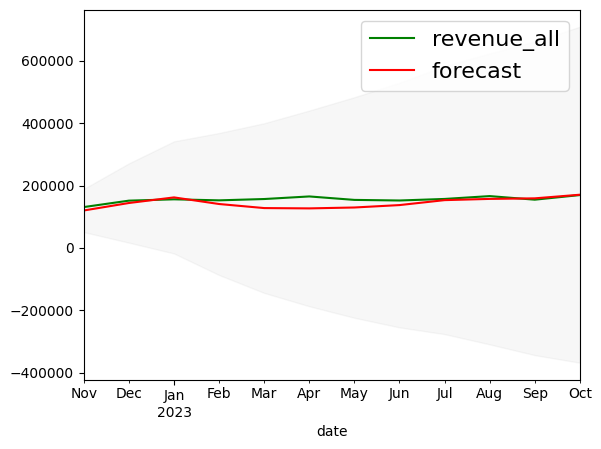

In [331]:
sarima_metric = plot_forecast(train_data, 
              test_data,
              forecast,
              forecast_int,
              model_name="SARIMA")
plt.show()

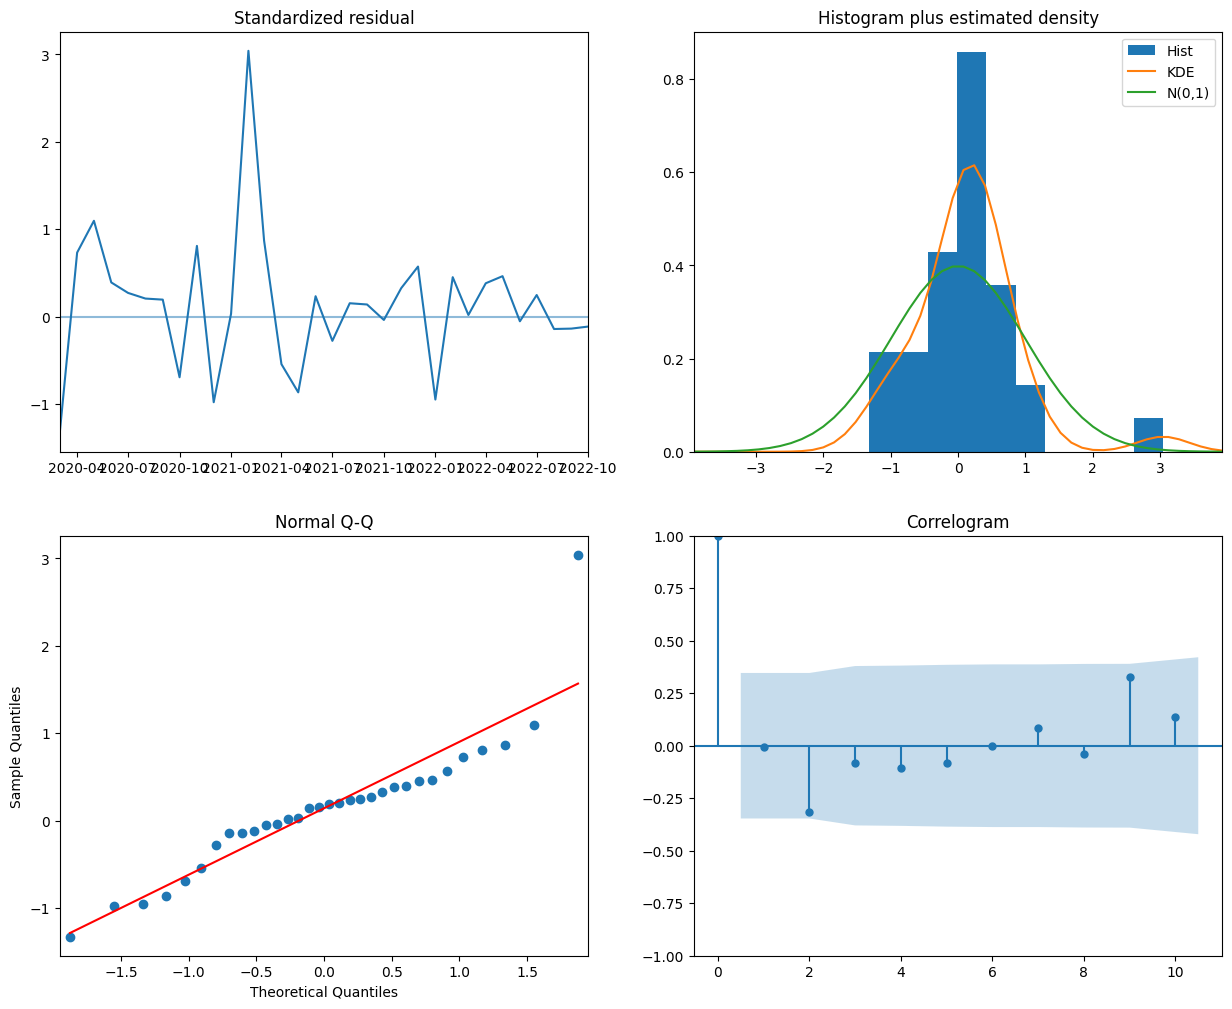

In [332]:
SARIMAModel.plot_diagnostics(figsize=(15,12))
plt.show()

## SARIMAX

with covid cases per month in Thai

In [333]:
import pandas as pd
thai_covid_data  = pd.read_excel("../raw_data/data_thai_covid_case.xlsx")

In [334]:
thai_covid_data = thai_covid_data[["date", "new_cases"]]
thai_covid_data["new_cases"] = thai_covid_data["new_cases"].fillna(0)

In [335]:
thai_covid_data["year"] = thai_covid_data["date"].dt.year
thai_covid_data["month"] = thai_covid_data["date"].dt.month


In [336]:
thai_covid_data_groupby = thai_covid_data.groupby(["year", "month"]).sum("new_cases").reset_index()
thai_covid_data_groupby

,year,month,new_cases
0,2020,1,32.0
1,2020,2,41.0
2,2020,3,1613.0
3,2020,4,1303.0
4,2020,5,127.0
5,2020,6,90.0
6,2020,7,139.0
7,2020,8,102.0
8,2020,9,152.0
9,2020,10,216.0


In [337]:
thai_covid_data_groupby["date"] = pd.to_datetime(dict(year=thai_covid_data_groupby.year, month=thai_covid_data_groupby.month, day=1))

In [338]:
thai_covid_data_groupby = thai_covid_data_groupby[["date", "new_cases"]]

In [339]:
new_date_data = list(pd.date_range(start=train_thai_revenue["date"].min(), freq="MS", end=thai_covid_data_groupby["date"].min()))

In [340]:
list_added_data = []
for sample_data in new_date_data:
    list_added_data.append({"date": sample_data, "new_cases": 0})

In [341]:
thai_covid_data_groupby = thai_covid_data_groupby.append(list_added_data)
thai_covid_data_groupby.sort_values(by = "date", inplace=True)

C:\Users\DUC\AppData\Local\Temp\ipykernel_17900\2663409483.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  thai_covid_data_groupby = thai_covid_data_groupby.append(list_added_data)


In [342]:
thai_covid_data_groupby

,date,new_cases
0,2019-01-01,0.0
1,2019-02-01,0.0
2,2019-03-01,0.0
3,2019-04-01,0.0
4,2019-05-01,0.0
...,...,...
43,2023-08-01,1231.0
44,2023-09-01,1067.0
45,2023-10-01,652.0
46,2023-11-01,1461.0


In [343]:
train_data = train_thai_revenue.set_index("date")
test_data = test_thai_revenue.set_index("date")
covid_data = thai_covid_data_groupby.set_index("date")

In [344]:
train_covid_data = covid_data[:len(train_thai_revenue)].values
test_covid_data = np.ones((HOLDOUT_MONTH, 1 )) * covid_data["new_cases"][-1]

In [345]:
import pmdarima as pm

SARIMAModel = pm.auto_arima(
                        y=train_data["revenue_all"],
                        X=train_covid_data,
                        start_p=1,
                        start_q=1, 
                        test= "adf",  # use adftest to find optimal 'd'
                        max_p=3,
                        max_q=3,
                        m=12,
                        start_P=0,
                        seasonal=True,
                        D=1,
                        alpha=0.05,
                        suppress_warnings=True,
                        stepwise=True)

SARIMAModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   46
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 12)   Log Likelihood                -383.482
Date:                              Thu, 21 Dec 2023   AIC                            780.963
Time:                                      16:59:39   BIC                            791.439
Sample:                                  01-01-2019   HQIC                           784.488
                                       - 10-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0017      0.154      0.011      0.991      -0.299       0.303
ar.L1          0.4406      0.230      1.914      0.056      -0.011       0.892
ar.L2          0.0121      0.129      0.094      0.925      -0.241       0.265
ar.S.L12       0.2518      0.360      0.700      0.484      -0.453       0.957
ar.S.L24      -0.1770      0.138     -1.285      0.199      -0.447       0.093
ma.S.L12      -0.6942      0.504     -1.378      0.168      -1.682       0.293
sigma2      8.626e+08   1.18e-09   7.34e+17      0.000    8.63e+08    8.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                21.79
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.92
Prob(H) (two-sided):                  0.40   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+33. Standard errors may be unstable.
"""

In [346]:
forecast, forecast_int = SARIMAModel.predict(n_periods=HOLDOUT_MONTH,
                                             X=test_covid_data,
                                           return_conf_int=True,
                                          alpha=0.05)

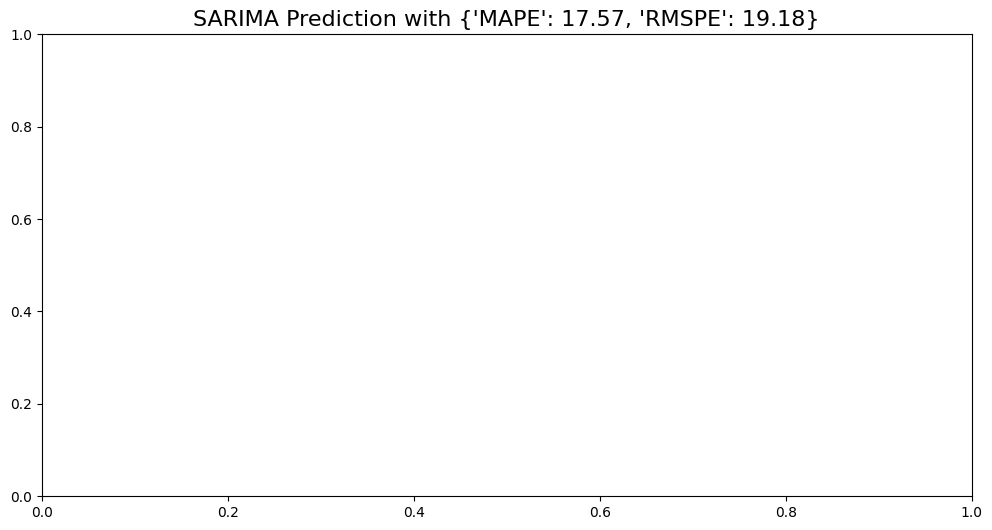

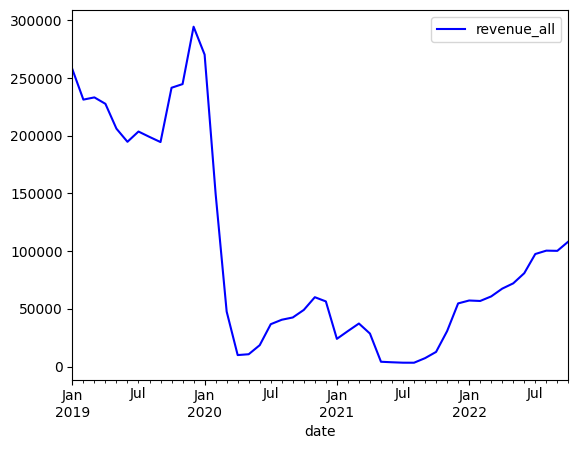

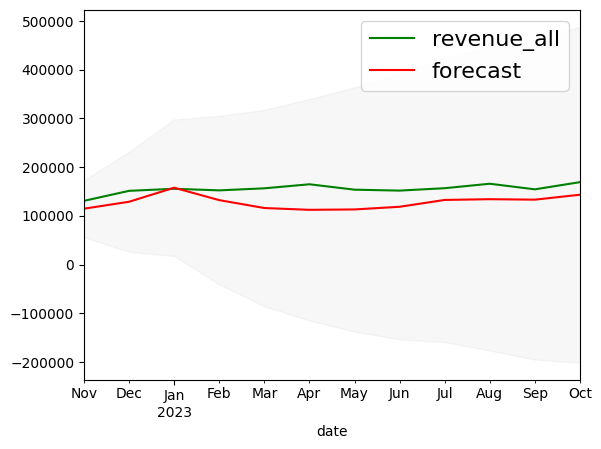

In [347]:
sarima_metric = plot_forecast(train_data, 
              test_data,
              forecast,
              forecast_int,
              model_name="SARIMAX")
plt.show()

## Prophet

## VAR